In [5]:
number_of_amp = 0

In [6]:
import random 

def RandomAmplification(circ, c): 
    """
    Input: a circuit, and scaling factor between 1 and 3 (inclusive)
    Output: circuit with amplified error rate using adding-pair-of-gates tactic
    """
    
    #probability to add a pair of gates 
    g = (c-1)/2
    
    #iterating over the circuit in string representation
    
    
    newqasm_str=""
    circ_str=circ.qasm()
    
    qregname=circ.qregs[0].name
    
    for line in iter(circ_str.splitlines()):
        
        if line.startswith('cx') or line.startswith('u3'):
            
            #doing a toss to see if we have to amplify 
            if random.randint(1,101) <= 100*g : 
                global number_of_amp
                number_of_amp+=1
                
                #adding the original line first 
                ##barrier 
                barrier ="""barrier q[0],q[1];"""
                newqasm_str+= barrier + '\n' + line + '\n'+ barrier + '\n'
                if line.startswith('cx'):
                    newqasm_str += cXPairAdder(line)
                else: 
                    newqasm_str += u3PairAdder(line)
            else: 
                newqasm_str+=line+"\n"
        else:
            newqasm_str+=line+"\n"

    circo=QuantumCircuit().from_qasm_str(newqasm_str)
    
    return circo 


In [7]:
def cXPairAdder(orig_gate_str): 
    """
    Input: a qasm string corresponding to a gate
    Output: a pair of gates in qasm string representation to amplify error in the given gate by factor of 3
    """
    #barrier for 2 qubit circuit only
    barrier ="""barrier q[0],q[1];"""
    
    return barrier + '\n' + orig_gate_str +'\n' +barrier + '\n'+orig_gate_str + '\n' + barrier + '\n'

In [49]:
def u3PairAdder(orig_gate_str): 
    """
    Input: a qasm string corresponding to a gate
    Output: a pair of gates in qasm string representation to amplify error in the given gate by factor of 3
    """
    # Converting the gate string to array 
    
    ##break up the string 
    strings = orig_gate_str.split("(")
    temp =[]
    for string in strings: 
        temp = temp + string.split(")")
    strings = temp 
    temp =[]
    for string in strings: 
        temp = temp + string.split(",")
    strings = temp 
    temp = []
    for string in strings: 
        temp = temp + string.split("*")
    strings = temp
    
    #Obtaining all useful information 
    gate = strings[0]
    qubit = strings[4]
    orig_angles = strings[1:4]
    
    #new angles 
    new_angles = orig_angles 
    
    ## U3 ^-1(  theta,  phi, lambda) = U3( theta , -pi - lambda, - pi - phi)
    
    ###Part 1: Inverting and adding - pi to 2nd and 3rd angle
    for i in range(1,3): 
        if new_angles[i][0] == '-': 
            new_angles[i] = str(-math.pi +float(new_angles[i][1:]))
        else: 
            new_angles[i] = str(-math.pi+ (-1)*float(new_angles[i]))
    ###Part 2: Switching the 2nd and 3rd angles
    new_angles = [new_angles[0], new_angles[2], new_angles[1]]
            

    #creating inverted gate
    new_gate_str = gate + '(' + new_angles[0] + ',' + new_angles[1] + ',' + new_angles[2] + ')' + qubit
    
    #barrier 
    barrier ="""barrier q[0];"""
    
    return barrier + '\n' + new_gate_str + '\n'+ barrier + '\n' + orig_gate_str + '\n' + barrier + '\n'
    

In [50]:
from qiskit import QuantumCircuit 
import random
import math
from qiskit import Aer, execute

percent_counts_0 = 0
simulator = Aer.get_backend('qasm_simulator')
circs = []

for i in range(100): 
    angle_1 = random.uniform(-math.pi,math.pi)
    angle_2 = random.uniform(-math.pi,math.pi)
    angle_3 = random.uniform(-math.pi,math.pi)
    string = 'u3' + '(' + str(angle_1) + ',' + str(angle_2) + ',' + str(angle_3) + ')' + ' q[0];'
    whole_new_string = 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[1];\ncreg c[1];\n' + u3PairAdder(string) + 'measure q[0] -> c[0];\n'
    #print(whole_new_string)
    new_circ = QuantumCircuit.from_qasm_str(whole_new_string)
    circs.append(new_circ)
    job = execute(new_circ, backend = simulator, shots = 1024)
    counts = job.result().get_counts()
    p_counts_0 = int(counts['0'])/1024
    percent_counts_0+=(p_counts_0)
    if i%10 == 0: 
        print( 'After ' + str(i) + ' samples, counts are ' + str(percent_counts_0))


After 0 samples, counts are 1.0
After 10 samples, counts are 11.0
After 20 samples, counts are 21.0
After 30 samples, counts are 31.0
After 40 samples, counts are 41.0
After 50 samples, counts are 51.0
After 60 samples, counts are 61.0
After 70 samples, counts are 71.0
After 80 samples, counts are 81.0
After 90 samples, counts are 91.0


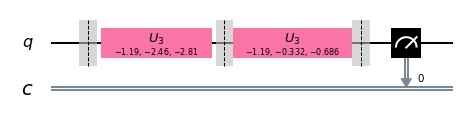

In [44]:
circs[0].draw(output = 'mpl')

In [25]:
number_of_amp = 0
for i in range(1000): 
    if (i%10) == 0: 
        print('Number of samples are ' + str(i) + ' and number of gates amplified is ' + str(number_of_amp))
    RandomAmplification(circ, 2)

Number of samples are 0 and number of gates amplified is 0
Number of samples are 10 and number of gates amplified is 19
Number of samples are 20 and number of gates amplified is 38
Number of samples are 30 and number of gates amplified is 59
Number of samples are 40 and number of gates amplified is 79
Number of samples are 50 and number of gates amplified is 96
Number of samples are 60 and number of gates amplified is 116
Number of samples are 70 and number of gates amplified is 140
Number of samples are 80 and number of gates amplified is 160
Number of samples are 90 and number of gates amplified is 177
Number of samples are 100 and number of gates amplified is 197
Number of samples are 110 and number of gates amplified is 217
Number of samples are 120 and number of gates amplified is 234
Number of samples are 130 and number of gates amplified is 252
Number of samples are 140 and number of gates amplified is 276
Number of samples are 150 and number of gates amplified is 298
Number of 

KeyboardInterrupt: 

In [11]:
angle_1 = random.uniform(-math.pi,math.pi)
angle_2 = random.uniform(-math.pi,math.pi)
angle_3 = random.uniform(-math.pi,math.pi)
circ = QuantumCircuit(1)
circ.u3(angle_1, angle_2, angle_3, 0)
string = circ.qasm()
string

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[1];\nu3(1.6528969,2.1624174,1.5953142) q[0];\n'

In [18]:
angle_1 = random.uniform(-math.pi,math.pi)
angle_2 = random.uniform(-math.pi,math.pi)
angle_3 = random.uniform(-math.pi,math.pi)
string = 'u3' + '(' + str(angle_1) + ',' + str(angle_2) + ',' + str(angle_3) + ')' + ' q[0];'
whole_new_string = 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[1];\n' + u3PairAdder(string)
#print(whole_new_string)
new_circ = QuantumCircuit.from_qasm_str(whole_new_string)
job = execute(new_circ, backend = simulator, shots = 1024)
counts = job.result().get_counts()

QiskitError: 'No counts for experiment "0"'

In [20]:
job.result()

Result(backend_name='qasm_simulator', backend_version='0.5.1', date=datetime.datetime(2020, 8, 3, 8, 30, 36, 6876), header=Obj(backend_name='qasm_simulator', backend_version='0.5.1'), job_id='08eb663d-c2f7-4997-818d-97585ac21901', metadata={'max_memory_mb': 4025, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken': 0.0002518}, qobj_id='f3514ec0-fbc4-4986-8590-8978128a8bbd', results=[ExperimentResult(data=ExperimentResultData(), header=Obj(clbit_labels=[], creg_sizes=[], memory_slots=0, n_qubits=1, name='circuit12', qreg_sizes=[['q', 1]], qubit_labels=[['q', 0]]), meas_level=<MeasLevel.CLASSIFIED: 2>, metadata={'measure_sampling': True, 'method': 'statevector', 'parallel_shots': 1, 'parallel_state_update': 4}, seed_simulator=3247070292, shots=1024, status='DONE', success=True, time_taken=0.000178)], status='COMPLETED', success=True, time_taken=0.0)

In [22]:
job.result().get_counts()

QiskitError: 'No counts for experiment "0"'

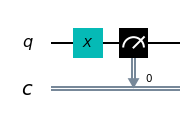

In [26]:
circ = QuantumCircuit(1,1)
circ.x(0)
circ.measure(0, 0)
circ.draw(output = 'mpl')

In [27]:
job = execute(circ, backend = simulator, shots = 1024)
counts = job.result().get_counts()

In [28]:
circ.qasm()

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[1];\ncreg c[1];\nx q[0];\nmeasure q[0] -> c[0];\n'